<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data,-policy-and-model-initialization" data-toc-modified-id="Data,-policy-and-model-initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data, policy and model initialization</a></span><ul class="toc-item"><li><span><a href="#Load-contact-data" data-toc-modified-id="Load-contact-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load contact data</a></span></li><li><span><a href="#Load-publically-available-data-from-Sciensano" data-toc-modified-id="Load-publically-available-data-from-Sciensano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load publically available data from Sciensano</a></span></li><li><span><a href="#Load-posterior-parameter-distributions-of-calibrated-parameters" data-toc-modified-id="Load-posterior-parameter-distributions-of-calibrated-parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load posterior parameter distributions of calibrated parameters</a></span></li></ul></li><li><span><a href="#Scenario-1:-no-vaccination" data-toc-modified-id="Scenario-1:-no-vaccination-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scenario 1: no vaccination</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Try-out-functions" data-toc-modified-id="Try-out-functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Try-out functions</a></span></li><li><span><a href="#Scenario-2:-Vaccination-old-to-young,-eff=0.7" data-toc-modified-id="Scenario-2:-Vaccination-old-to-young,-eff=0.7-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scenario 2: Vaccination old to young, eff=0.7</a></span></li><li><span><a href="#Scenario-3:-First-the-most-mobile,-eff=0.7" data-toc-modified-id="Scenario-3:-First-the-most-mobile,-eff=0.7-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scenario 3: First the most mobile, eff=0.7</a></span></li><li><span><a href="#Scenario-4:-Vaccination-old-to-young,-eff=0.9" data-toc-modified-id="Scenario-4:-Vaccination-old-to-young,-eff=0.9-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scenario 4: Vaccination old to young, eff=0.9</a></span></li><li><span><a href="#Scenario-5:-First-the-most-mobile,-eff=0.9" data-toc-modified-id="Scenario-5:-First-the-most-mobile,-eff=0.9-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Scenario 5: First the most mobile, eff=0.9</a></span></li><li><span><a href="#Figures" data-toc-modified-id="Figures-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Figures</a></span></li><li><span><a href="#Fast-plotting" data-toc-modified-id="Fast-plotting-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Fast plotting</a></span></li></ul></div>


*Authored by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, google_lockdown
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator
from covid19model.visualization.optimization import plot_fit, traceplot

plt.rcParams.update({'font.size': 12, 'axes.grid':False})

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Data, policy and model initialization

## Load contact data

In [2]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='all')
# Define the number of age categories
levels = initN.size

initN, Nc_home_15, Nc_work_15, Nc_schools_15, Nc_transport_15, Nc_leisure_15, Nc_others_15, Nc_total_15 = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_15_min')
initN, Nc_home_1hr, Nc_work_1hr, Nc_schools_1hr, Nc_transport_1hr, Nc_leisure_1hr, Nc_others_1hr, Nc_total_1hr = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_one_hour')

In [3]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
Nc_15min = {'total': Nc_total_15, 'home': Nc_home_15, 'work': Nc_work_15, 'schools': Nc_schools_15, 'transport': Nc_transport_15, 'leisure': Nc_leisure_15, 'others': Nc_others_15}
Nc_1hr = {'total': Nc_total_1hr, 'home': Nc_home_1hr, 'work': Nc_work_1hr, 'schools': Nc_schools_1hr, 'transport': Nc_transport_1hr, 'leisure': Nc_leisure_1hr, 'others': Nc_others_1hr}

## Load publically available data from Sciensano

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)


In [5]:
df_google = google.get_google_mobility_data(update=False, plot=False)

## Load posterior parameter distributions of calibrated parameters

In [6]:
# Load samples dictionary of the first wave
with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-13_WAVE2_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)

with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states_sept = json.load(fp) 

In [ ]:
samples_dict.keys()

In [ ]:
fig,ax = plt.subplots()
pd.Series(samples_dict['beta']).hist()
pd.Series(samples_dict['tau']).hist()

In [7]:
UL = 0.975
LL = 0.025

In [8]:
start_calibration = '2020-09-01'
end_calibration = '2020-11-12'
end_sim = '2021-03-01'

In [9]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
               'prevention':0.5
              })

# Scenario 1: no vaccination

In [10]:
# Initialize the model
model_S1 = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'Nc': google_lockdown})

In [ ]:
# end_sim = '2021-01-01'

# fig,ax=plt.subplots(figsize=(10,4))
# for i in range(20):
#     # Sampling
#     model_S1.parameters['beta'] = np.random.choice(samples_dict['beta'])
#     idx,model_S1.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
#     model_S1.parameters['tau'] = samples_dict['tau'][idx]   
#     # Simulate
#     y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0)
#     # Plot
#     ax.plot(y_model_S1['time'],y_model_S1["H_in"].sum(dim="Nc"),color='blue',alpha=0.02)

# ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

# ax = _apply_tick_locator(ax)
# ax.set_xlim('2020-09-01',end_sim)

# Functions

In [11]:
from math import floor

In [12]:
def vacc_policy(t, vaccN, daily, order):
    
    """
    t : timestamp
        current time in simulation
    vaccN : array
        population per age group to be vaccinated for effectiveness
    daily : int
        daily number of people vaccinated
    order : list
        ordered list of number 0 to 8, representing 9 age groups
    """
    
    vaccinations = np.array([0.0]*9)

    # Define additional dates where intensity or school policy changes
    t0 = pd.Timestamp('2020-09-01') # start vaccination
    t1 = t0 + pd.Timedelta(floor(vaccN[order[0]]/daily), unit='D') # end vaccination group 0
    t2 = t1 + pd.Timedelta(floor(vaccN[order[1]]/daily), unit='D') # end vaccination group 1
    t3 = t2 + pd.Timedelta(floor(vaccN[order[2]]/daily), unit='D') 
    t4 = t3 + pd.Timedelta(floor(vaccN[order[3]]/daily), unit='D') 
    t5 = t4 + pd.Timedelta(floor(vaccN[order[4]]/daily), unit='D')
    t6 = t5 + pd.Timedelta(floor(vaccN[order[5]]/daily), unit='D') 
    t7 = t6 + pd.Timedelta(floor(vaccN[order[6]]/daily), unit='D') 
    t8 = t7 + pd.Timedelta(floor(vaccN[order[7]]/daily), unit='D') 
    t9 = t8 + pd.Timedelta(floor(vaccN[order[8]]/daily), unit='D') # end vaccination group 8

    if t < t1:
        vaccinations[order[0]] = daily/vaccN[order[0]]
        return vaccinations
    
    if t < t2:
        vaccinations[order[1]] = daily/vaccN[order[1]]
        return vaccinations
    
    if t < t3:
        vaccinations[order[2]] = daily/vaccN[order[2]]
        return vaccinations
    
    if t < t4:
        vaccinations[order[3]] = daily/vaccN[order[3]]
        return vaccinations
    
    if t < t5:
        vaccinations[order[4]] = daily/vaccN[order[4]]
        return vaccinations
    
    if t < t6:
        vaccinations[order[5]] = daily/vaccN[order[5]]
        return vaccinations
    
    if t < t7:
        vaccinations[order[6]] = daily/vaccN[order[6]]
        return vaccinations
    
    if t < t8:
        vaccinations[order[7]] = daily/vaccN[order[7]]
        return vaccinations
    
    else:
        vaccinations[order[8]] = daily/vaccN[order[8]]
        return vaccinations
    

In [16]:
def calc_vaccN(suscN, expN, recN, vaccinated_prop, order, effectivity):
    
    """
    Parameters
    ----------
    
    suscN : array
        numbers of susceptibles per age group
    expN : array
        numbers of exposed per age group
    recN : array
        numbers of recovered per age group
    vaccinated_prop: float
        proportion of the population already vaccinated (following the same strategy as further implemented)
    order : list
        ordered list of number 0 to 8, representing 9 age groups  
       
    Returns
    ------
    
    vaccN : array
        numbers of people to vaccinate per age group
    new_suscN : array
        numbers of remaining susceptibles per age group, taking effectivity into account
    new_expN : array
        numbers of remaining exposed per age group, taking effectivity into account
    new_recN : array
        numbers of resulting recovered per age group
    """

    vaccN = suscN.copy()
    new_suscN = suscN.copy()
    new_expN = expN.copy()
    
    # every person who is vaccinated is considered immune, hence leaves vaccN
    vaccinated = np.sum(suscN)*vaccinated_prop
    for i in order:
        left_in_i = suscN[i] - vaccinated
        vaccinated = max(0,(vaccinated - suscN[i]))
        vaccN[i] =  max(0,left_in_i)
        
    # in reality, only a proportion of the vaccinated people are not susceptible anymore
    real_vaccinated = np.sum(suscN)*vaccinated_prop*effectivity
    for i in order:
        left_in_i = suscN[i] - real_vaccinated
        real_vaccinated = max(0,(real_vaccinated - suscN[i]))
        new_suscN[i] =  max(0,left_in_i)
        
    # we suppose that in the exposed pool, a proportional number of people cannot be infected anymore
#     real_vaccinated = np.sum(expN)*vaccinated_prop*effectivity
#     for i in order:
#         left_in_i = expN[i] - real_vaccinated
#         real_vaccinated = max(0,(real_vaccinated - expN[i]))
#         new_expN[i] =  max(0,left_in_i)
        
    susc_to_rec = suscN - new_suscN
    exp_to_rec = expN - new_expN
    new_recN = recN + susc_to_rec + exp_to_rec
        
    return vaccN, new_suscN, new_expN, new_recN

In [14]:
def vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_no_vacc, levels=levels):
    suscN = np.array(initial_states_no_vacc['S'])
    expN = np.array(initial_states_no_vacc['E'])
    recN = np.array(initial_states_no_vacc['R'])
    new_vaccN, new_suscN, new_expN, new_recN = calc_vaccN(suscN, expN, recN, vaccinated_prop, order, effectivity)
    params.update({'vaccN' : new_vaccN,
                   'daily' : daily,
                   'order' : order,
                   'e' : np.array([effectivity]*levels)
                 })
    # Adapt initial states
    initial_states = initial_states_no_vacc.copy()
    initial_states.update({'S' : new_suscN,
                           'E' : new_expN,
                           'R' : new_recN})
    return models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': google_lockdown,
                                                                                   'v':vacc_policy})

In [15]:
def plot_band(ax, y_model, var, color, label):
    ax.fill_between(pd.to_datetime(y_model['time'].values),y_model[var].quantile(LL,dim="draws").sum(dim="Nc"), 
                    y_model[var].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.30, facecolor = color)
    ax.plot(y_model['time'],y_model[var].mean(dim="draws").sum(dim="Nc"), color=color, label=label, lw=2)
    return

# Try-out functions

In [ ]:
suscN = initial_states['S']

In [ ]:
suscN

In [ ]:
    vaccN = np.array(suscN)*0.75
    new_vaccN = vaccN.copy()

    vaccinated = np.sum(suscN)*0.3
    for i in order:
        left_in_i = vaccN[i] - vaccinated
        vaccinated = max(0,(vaccinated - vaccN[i]))
        new_vaccN[i] =  max(0,left_in_i)

In [ ]:
vaccN

In [ ]:
new_vaccN

In [ ]:
# def vacc_policy_old_to_young(t, initN, daily):
    
#     vacc_level = 0.75
#     vaccN = initN*vacc_level

#     # Define additional dates where intensity or school policy changes
#     t1 = pd.Timestamp('2020-09-01') # start vaccination 80+
#     t2 = t1 + pd.Timedelta(floor(vaccN[7]/daily), unit='D') # start vaccination 70+
#     t3 = t2 + pd.Timedelta(floor(vaccN[8]/daily), unit='D') # start vacciation 60+
#     t4 = t3 + pd.Timedelta(floor(vaccN[6]/daily), unit='D') # start vacciation 50+
#     t5 = t4 + pd.Timedelta(floor(vaccN[5]/daily), unit='D') # start vacciation 40+
#     t6 = t5 + pd.Timedelta(floor(vaccN[4]/daily), unit='D') # start vacciation 30+

    
#     vaccinations = {'0-9':0,
#                     '10-19':0,
#                     '20-29':0,
#                     '30-39':0,
#                     '40-49':0,
#                     '50-59':0,
#                     '60-69':0,
#                     '70-79':0,
#                     '80+':0}
#     if t < t2:
#         vaccinations.update({'70-79':daily/vaccN[7]})
#         return [value for key, value in vaccinations.items()]
#     elif t < t3:
#         vaccinations.update({'80+':daily/vaccN[8]})
#         return [value for key, value in vaccinations.items()]
#     elif t < t4:
#         vaccinations.update({'60-69':daily/vaccN[6]})
#         return [value for key, value in vaccinations.items()]
#     elif t < t5:
#         vaccinations.update({'50-59':daily/vaccN[5]})
#         return [value for key, value in vaccinations.items()]
#     elif t < t6:
#         vaccinations.update({'40-49':daily/vaccN[4]})
#         return [value for key, value in vaccinations.items()]
#     else:
#         vaccinations.update({'30-39':daily/vaccN[3]})
#         return [value for key, value in vaccinations.items()]

In [ ]:
# times = pd.date_range(start='2020-09-01', freq='D', end='2021-01-01')
# for t in times:
#     v = vacc_policy_old_to_young(t, initN, 10000)
#     print(v)

In [ ]:
# for t in times:
#     v = vacc_policy(t, initN, 10000, order = [7,8,6,5,4,3,2,1,0])
#     print(v)

In [ ]:
# def vacc_policy(t, initN, daily, order):
    
#     vaccinations = [0]*9
#     vacc_level = 0.75
#     vaccN = initN*vacc_level

#     vacc_df = pd.DataFrame({'age_group':np.arange(0,9)})
#     vacc_df['v'] = vacc_df.age_group.apply(lambda x: daily/vaccN[x])
#     vacc_df['end_time'] = None
    
#     end_times = {}
#     end_times[0] = pd.Timestamp('2020-09-01')
    
#     for i in np.arange(1,len(order)+1):
#         end_times[i] = end_times[i-1] + pd.Timedelta(floor(vaccN[order[i-1]]/daily), unit='D')
#         vacc_df.loc[vacc_dc.age_group==order[i-1],'end_time'] = end_times[i]
    
#     v = vacc_df[t<vacc_df.end_time].sort_values(by='end_time').iloc[0]['v']
#     age = vacc_df[t<vacc_df.end_time].sort_values(by='end_time').iloc[0]['age_group']

#     vaccinations[int(age)] = v
    
#     return vaccinations

# Scenario 2: Vaccination old to young, eff=0.7

In [17]:
order = [8,7,6,5,4,3,2,1,0]
effectivity = 0.7
daily=10000

In [18]:
vaccinated_prop = 0
model_S2a = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.1
model_S2b = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.3
model_S2c = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.5
model_S2d = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)

In [19]:
n=50
y_model_S2a = model_S2a.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S2b = model_S2b.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S2c = model_S2c.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S2d = model_S2d.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [ ]:
# fig,ax = plt.subplots()
# y_model_S1['E'].sum(dim='Nc'). plot(ax=ax, c='green', label='no vacc')
# y_model_S2a['E'].sum(dim='Nc'). plot(ax=ax, c='blue', label='S2a')
# plt.legend()

# Scenario 3: First the most mobile, eff=0.7

In [20]:
order = [2,3,4,5,6,7,8,1,0]
effectivity = 0.7
daily=10000

In [21]:
vaccinated_prop = 0
model_S3a = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.1
model_S3b = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.3
model_S3c = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.5
model_S3d = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)

In [22]:
n=50
y_model_S3a = model_S3a.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S3b = model_S3b.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S3c = model_S3c.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S3d = model_S3d.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

# Scenario 4: Vaccination old to young, eff=0.9

In [23]:
order = [8,7,6,5,4,3,2,1,0]
effectivity = 0.9
daily=10000

In [24]:
vaccinated_prop = 0
model_S4a = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.1
model_S4b = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.3
model_S4c = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.5
model_S4d = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)

In [25]:
n=50
y_model_S4a = model_S4a.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S4b = model_S4b.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S4c = model_S4c.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S4d = model_S4d.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

# Scenario 5: First the most mobile, eff=0.9

In [26]:
order = [2,3,4,5,6,7,8,1,0]
effectivity = 0.9
daily=10000

In [27]:
vaccinated_prop = 0
model_S5a = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.1
model_S5b = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.3
model_S5c = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.5
model_S5d = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)

In [28]:
n=50
y_model_S5a = model_S5a.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S5b = model_S5b.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S5c = model_S5c.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S5d = model_S5d.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

# Figures

<IPython.core.display.Javascript object>


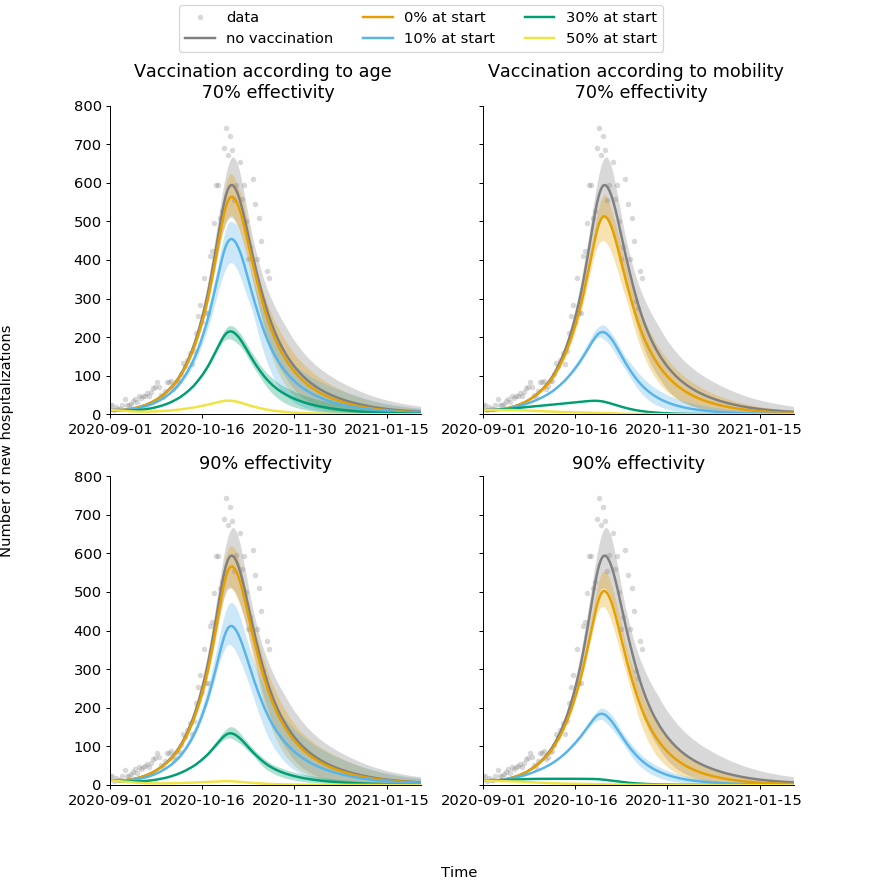

In [30]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(10,10), nrows=2, ncols=2, sharex=True, sharey=True)
ax1.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax1, y_model_S1, 'H_in', 'gray', 'no vaccination')
plot_band(ax1, y_model_S2a, 'H_in', 'C0', '0% at start')
plot_band(ax1, y_model_S2b, 'H_in', 'C1', '10% at start')
plot_band(ax1, y_model_S2c, 'H_in', 'C2', '30% at start')
plot_band(ax1, y_model_S2d, 'H_in', 'C3', '50% at start')

ax1.set_xlim('2020-09-01', '2021-02-01')
ax1.set_xticks(pd.date_range('2020-09-01', '2021-01-15', periods=4))
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.set_title('Vaccination according to age \n 70% effectivity')


ax2.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax2, y_model_S1, 'H_in', 'gray', 'no vaccination')
plot_band(ax2, y_model_S3a, 'H_in', 'C0', '0% at start')
plot_band(ax2, y_model_S3b, 'H_in', 'C1', '10% at start')
plot_band(ax2, y_model_S3c, 'H_in', 'C2', '30% at start')
plot_band(ax2, y_model_S3d, 'H_in', 'C3', '50% at start')

ax2.set_xlim('2020-09-01', '2021-02-01')
ax2.set_xticks(pd.date_range('2020-09-01', '2021-01-15', periods=4))
ax2.xaxis.set_tick_params(which='both', labelbottom=True)
ax2.set_title('Vaccination according to mobility \n 70% effectivity')


ax3.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax3, y_model_S1, 'H_in', 'gray', 'no vaccination')
plot_band(ax3, y_model_S4a, 'H_in', 'C0', '0% at start')
plot_band(ax3, y_model_S4b, 'H_in', 'C1', '10% at start')
plot_band(ax3, y_model_S4c, 'H_in', 'C2', '30% at start')
plot_band(ax3, y_model_S4d, 'H_in', 'C3', '50% at start')

ax3.set_xlim('2020-09-01', '2021-02-01')
ax3.set_xticks(pd.date_range('2020-09-01', '2021-01-15', periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('90% effectivity')

ax4.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax4, y_model_S1, 'H_in', 'gray', 'no vaccination')
plot_band(ax4, y_model_S5a, 'H_in', 'C0', '0% at start')
plot_band(ax4, y_model_S5b, 'H_in', 'C1', '10% at start')
plot_band(ax4, y_model_S5c, 'H_in', 'C2', '30% at start')
plot_band(ax4, y_model_S5d, 'H_in', 'C3', '50% at start')

ax4.set_xlim('2020-09-01', '2021-02-01')
ax4.set_xticks(pd.date_range('2020-09-01', '2021-01-15', periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('90% effectivity')


ax1.legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=3)
ax1.set_ylim(0,800)
fig.text(0, 0.5, 'Number of new hospitalizations', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


fig.savefig('../results/predictions/national/vaccination_wave2.pdf')

# Fast plotting

In [ ]:
end_sim = '2021-01-01'

fig,ax=plt.subplots(figsize=(10,4))
model_S2c.parameters['beta'] = np.mean(samples_dict['beta'])
model_S2c.parameters['l'] = np.mean(samples_dict['l'])
model_S2c.parameters['tau'] = np.mean(samples_dict['tau'])
y_model_S2c = model_S2c.sim(end_sim,start_date=start_calibration,warmup=0)

ax.plot(y_model_S2c['time'],y_model_S2c["H_in"].sum(dim="Nc"),color='blue',alpha=1)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)

In [ ]:
    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-09-01') # start vaccination 80+
    t2 = t1 + pd.Timedelta(floor(initN[8]/daily), unit='D')

In [ ]:
n=100
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [ ]:
fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S1['time'].values),y_model_S1["H_in"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S1["H_in"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S1['time'],y_model_S1["H_in"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_in'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Number of new hospitalizations')
ax = _apply_tick_locator(ax)

In [ ]:

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S1['time'].values),y_model_S1["H_tot"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S1["H_tot"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S1['time'],y_model_S1["H_tot"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_tot'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Total patients in Belgian hospitals')
ax = _apply_tick_locator(ax)

In [ ]:
for t in times:
    v = vacc_policy_old_to_young(t, initN, daily=10000)
    print(v)